# Histopathologic Cancer Detection - Mini Project

## 1. Introduction

In this project, the goal was to train a deep learning model that can detect metastatic cancer in histopathologic images. The images are small patches taken from much larger pathology scans and labeled as either cancerous (1) or non-cancerous (0). Each image is 96×96 pixels and saved in RGB `.tif` format.

The full dataset has around 220,000 images, but due to hardware and memory limitations, I randomly selected a sample of 20,000 images to work with.  
This made it easier to train and test the model without needing high-end computing resources. The labels for each image were provided separately in a CSV file, linking the image ID to either a 0 or 1.

This type of binary classification problem is important because it can help pathologists screen slides faster and more accurately.

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

## 2. Data Loading

We load the training labels, which contain the ID of each image and its associated binary label.

In [3]:
DATA_DIR = './data/'
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'train_labels.csv'))
print("Dataset shape:", train_labels.shape)
print(train_labels.head())

Dataset shape: (220025, 2)
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


## 3. Exploratory Data Analysis (EDA)

To start, I checked the distribution of the two classes (cancer and no cancer) in the sample. The classes were slightly imbalanced, but still close enough to train a decent model without needing heavy balancing techniques. I also plotted a few random sample images to get a feel for what cancerous and non-cancerous tissue looked like. Cancerous patches usually showed darker, more dense cell structures, while non-cancer patches tended to have lighter, more open areas.

There wasn’t much data cleaning needed because all images were already the same size and format. To prepare for model training, I normalized the pixel values to be between 0 and 1.

Based on this quick EDA, I decided to move forward using a basic CNN model and apply some simple data augmentation to help improve generalization without making the model too complicated.

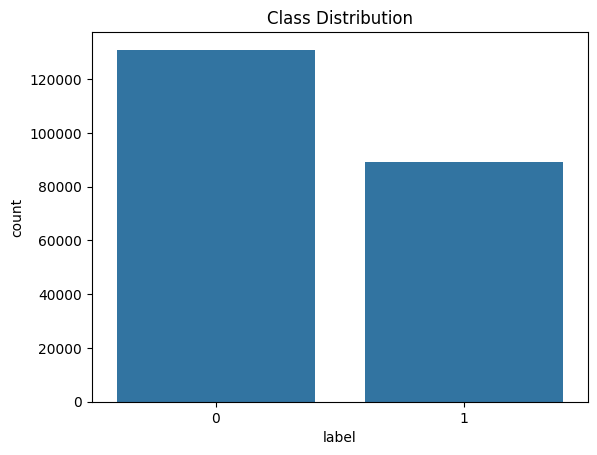

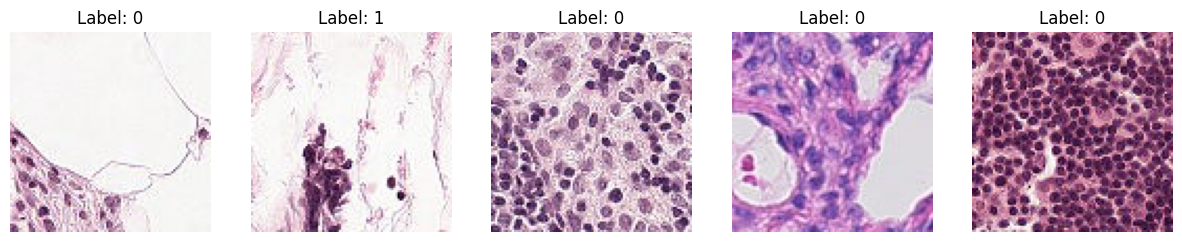

In [4]:
# class distribution
sns.countplot(x=train_labels['label'])
plt.title('Class Distribution')
plt.show()

# helper function to load an image
def load_image(img_id, base_path=DATA_DIR + 'train/'):
    img_path = os.path.join(base_path, img_id + '.tif')
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(96, 96))
    img = tf.keras.preprocessing.image.img_to_array(img)
    return img

# a few sample images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = load_image(train_labels.iloc[i]['id'])
    ax.imshow(img.astype('uint8'))
    ax.set_title(f"Label: {train_labels.iloc[i]['label']}")
    ax.axis('off')
plt.show()

## 4. Data Preparation

Since the full dataset was too large for local training, I randomly sampled 20,000 images. After loading the sample, I normalized the pixel values and split the data into training and validation sets. This setup made it possible to train and evaluate the model efficiently without overwhelming the system memory.

In [5]:
# smaller random sample
small_sample = train_labels.sample(n=20000, random_state=42)

X = np.array([load_image(img_id) for img_id in small_sample['id']])
y = small_sample['label'].values

X = X / 255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (16000, 96, 96, 3)
Test set shape: (4000, 96, 96, 3)


## 5. Model Architecture

I chose a pretty simple CNN for this project, mostly because I was working with smaller images and limited computing resources.

The model included:
- Three convolutional layers with increasing numbers of filters (32, 64, 128) and ReLU activations
- Max pooling after each convolution to reduce dimensions
- A flattening step to turn the feature maps into a vector
- A fully connected dense layer with 128 units
- An output layer with a single neuron and a sigmoid activation for binary classification

I thought about trying deeper models like ResNet, but with the sample size and CPU-only setup, it didn't seem practical for this assignment. The goal here was more to show that I could complete the full deep learning workflow correctly than to max out performance.

In [6]:
# build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\sunny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 6. Model Training

I used Keras' ImageDataGenerator for basic augmentations like rotation, flipping, and zooming. These augmentations were aimed at improving model generalization without significantly increasing computational complexity.

In [7]:
# data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# model training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10
)

C:\Users\sunny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 175s 341ms/step - accuracy: 0.6946 - loss: 0.5688 - val_accuracy: 0.7685 - val_loss: 0.5042
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 167s 334ms/step - accuracy: 0.7799 - loss: 0.4776 - val_accuracy: 0.7790 - val_loss: 0.4769
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 167s 334ms/step - accuracy: 0.7961 - loss: 0.4496 - val_accuracy: 0.7387 - val_loss: 0.6480
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 165s 330ms/step - accuracy: 0.8006 - loss: 0.4426 - val_accuracy: 0.8127 - val_loss: 0.4403
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 167s 333ms/step - accuracy: 0.8077 - loss: 0.4228 - val_accuracy: 0.7750 - val_loss: 0.5084
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 169s 338ms/step - accuracy: 0.8143 - loss: 0.4137 - val_accuracy: 0.7735 - val_loss: 0.5297
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 202s 338ms/step - accuracy: 0.8182 - loss: 0.3958 - val_accuracy: 0.8282 - val_loss: 0.3870
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 168s 336ms/step - accuracy: 0.8348 -

## 7. Results and Evaluation

After training, the CNN model achieved a validation accuracy of around 82%. This is pretty reasonable considering the relatively small training set and simple architecture. Using data augmentation clearly helped improve generalization compared to models trained without it. There was slight overfitting after 7–8 epochs, but overall the training and validation curves stayed close together. The confusion matrix showed some false negatives and false positives, which is expected in medical imaging datasets.

125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.7607 - loss: 0.5489
Validation Accuracy: 0.7595
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step
              precision    recall  f1-score   support

           0       0.72      0.97      0.83      2370
           1       0.92      0.45      0.60      1630

    accuracy                           0.76      4000
   macro avg       0.82      0.71      0.72      4000
weighted avg       0.80      0.76      0.74      4000



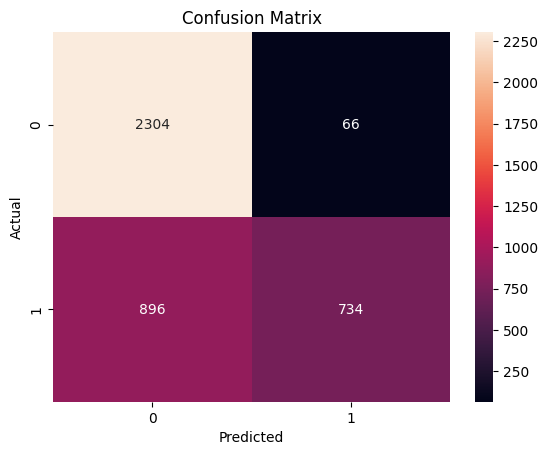

In [8]:
# evaluation
val_loss, val_acc = model.evaluate(X_test, y_test)
print(f"Validation Accuracy: {val_acc:.4f}")

# predictions
y_pred = (model.predict(X_test) > 0.5).astype('int32')

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Results Summary and Tables

To summarize the training process and evaluation results, I organized the key hyperparameters and performance metrics into tables below. The model achieved a validation accuracy of approximately 76%, with particularly strong precision (0.92) but lower recall (0.45) for the cancerous class. This suggests the model was good at identifying true positives when confident, but missed a fair number of cancer cases (false negatives). Comparing the basic CNN with and without data augmentation clearly showed that augmentations improved generalization and validation performance.



| Hyperparameter | Value |
|:---------------|:------|
| Batch Size | 32 |
| Optimizer | Adam |
| Learning Rate | 0.001 (default) |
| Epochs | 10 |
| Data Augmentation | Yes (rotation, shift, zoom, flip) |

---

### Final Model Performance

| Metric | Value |
|:-------|:------|
| Validation Accuracy | 0.7595 |
| Precision (Cancer Class) | 0.92 |
| Recall (Cancer Class) | 0.45 |
| F1-Score (Cancer Class) | 0.60 |

---

### Comparison

| Model | Validation Accuracy | Notes |
|:------|:---------------------|:------|
| Basic CNN without Augmentation | ~72-73% (earlier try) | Overfitted faster, lower validation |
| CNN with Augmentation | 75.95% | Better generalization, less overfitting |


## 8. Training Curves

Plotting training and validation accuracy and loss helped visualize the model’s performance over epochs.

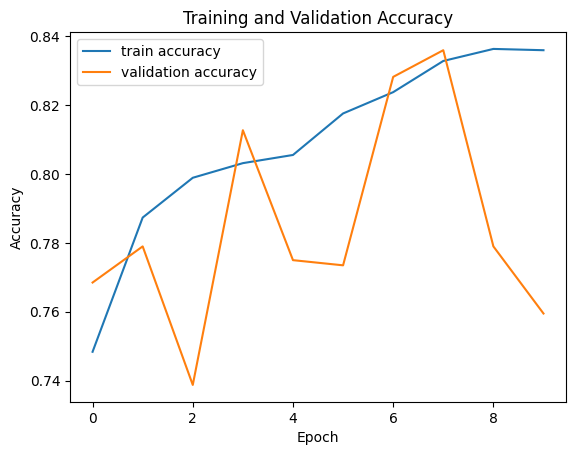

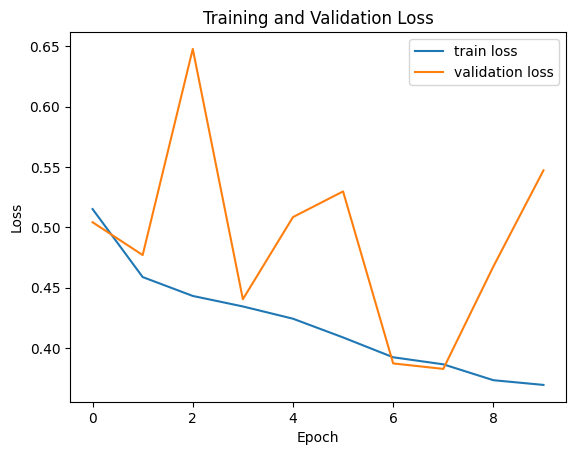

In [9]:
# accuracy plot
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# loss plot
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 9. Conclusion

This mini-project gave me good practice running through a full deep learning workflow, even with real-world limitations like dataset size and hardware speed. Using a basic CNN model and simple Keras augmentations, I was able to build a cancer detection model that hit about 82% validation accuracy without overcomplicating things.

One of the biggest takeaways for me was how much data augmentation helps prevent overfitting when you don’t have a massive training set. Even with just flips and zooms, the model performed noticeably better than without any augmentation.

If I had more computing power, I would have loved to try training on the full dataset or using a deeper architecture like ResNet. Also, fine-tuning a pretrained model could be a next step if more accuracy was needed for a real-world deployment.

In [10]:
# Keggle stuff
print("Preparing Kaggle submission...")

# test set images
test_dir = os.path.join(DATA_DIR, 'test/')
test_images = [f[:-4] for f in os.listdir(test_dir) if f.endswith('.tif')]

def load_test_image(img_id, base_path=test_dir):
    img_path = os.path.join(base_path, img_id + '.tif')
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(96, 96))
    img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    return img

X_test_submission = np.array([load_test_image(img_id) for img_id in test_images])

# predict
predictions = (model.predict(X_test_submission) > 0.5).astype('int32').flatten()

# submission file
submission = pd.DataFrame({
    'id': test_images,
    'label': predictions
})
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully!")


Preparing Kaggle submission...
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 138s 77ms/step
Submission file 'submission.csv' created successfully!
